In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import glob

In [0]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [6]:
#train_images = glob.glob('./input/train/*.png')
#train_labels = glob.glob('./input/train_cleaned/*.png')
#test_images = glob.glob('./input/test/*.png')

train_images = glob.glob('./drive/My Drive/Colab_Notebooks/datasets/train_1/train/*.png')
train_labels = glob.glob('./drive/My Drive/Colab_Notebooks/datasets/train_cleaned/train_cleaned/*.png')
test_images = glob.glob('./drive/My Drive/Colab_Notebooks/datasets/test/test/*.png')

print('Train_images : {}'.format(len(train_images)))
print('Train_labels : {}'.format(len(train_labels)))
print('Test_images : {}'.format(len(test_images)))

Train_images : 144
Train_labels : 144
Test_images : 72


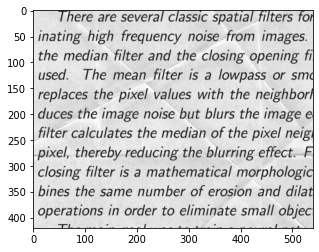

(420, 540)


In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img = cv2.imread(train_images[0], 0)
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)

In [8]:
# data read
X = []
Y = []
for images_path, labels_path in zip(train_images, train_labels):
    img = cv2.imread(images_path, 0)
    img = cv2.resize(img, (540, 420))
    lab = cv2.imread(labels_path, 0)
    lab = cv2.resize(lab, (540, 420))
    X.append(img)
    Y.append(lab)
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((144, 420, 540), (144, 420, 540))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=4)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((140, 420, 540), (4, 420, 540), (140, 420, 540), (4, 420, 540))

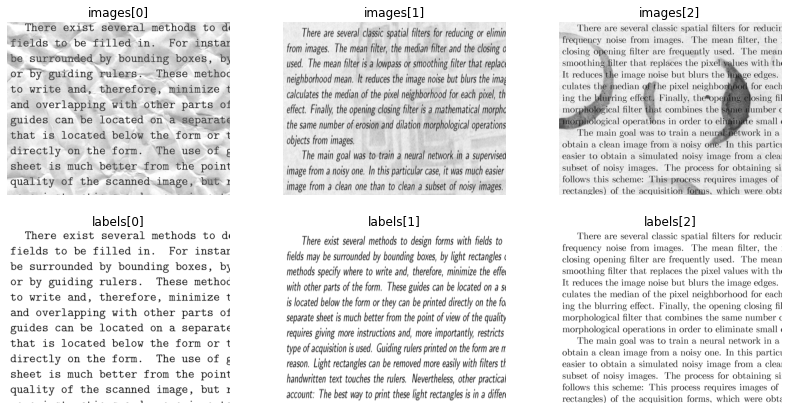

In [10]:
# images, labels show
fig, ax = plt.subplots(2, 3, figsize=(14,7))
for i, (x,y) in enumerate(zip(X_train[:3],Y_train[:3])):
    ax[0, i%3].imshow(x, cmap='gray')
    ax[0, i%3].set_title('images[{}]'.format(i))
    ax[0, i%3].axis('off')
    ax[1, i%3].imshow(y, cmap='gray')
    ax[1, i%3].set_title('labels[{}]'.format(i))
    ax[1, i%3].axis('off')
plt.show()

In [0]:
X_train = X_train.reshape((len(X_train), 1, 420, 540))
X_valid = X_valid.reshape((len(X_valid), 1, 420, 540))
Y_train = Y_train.reshape((len(Y_train), 1, 420, 540))
Y_valid = Y_valid.reshape((len(Y_valid), 1, 420, 540))

In [0]:
#print(len(X_train))
#print(len(X_valid))
#print(len(Y_train))
#print(len(Y_valid))

In [0]:
# train set
X_train = torch.from_numpy(X_train).type(torch.FloatTensor) / 255.
Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor) / 255.
# valid set
X_valid = torch.from_numpy(X_valid).type(torch.FloatTensor) / 255.
Y_valid = torch.from_numpy(Y_valid).type(torch.FloatTensor) / 255.

In [0]:
from torch.utils.data import DataLoader, TensorDataset
# images & labels set
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)
# data loader
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [0]:
class simple_CAE(nn.Module):
    def __init__(self):
        super(simple_CAE, self).__init__()
        self.nf = 64
        self.model = nn.Sequential(
            nn.Conv2d(1, self.nf, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.nf, self.nf*2, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            
            nn.ConvTranspose2d(self.nf*2, self.nf*2, 2, 2, 0, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.nf*2, self.nf, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.nf, self.nf, 2, 2, 0, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.nf, 1, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(1, 1, 3, 1, 1, bias=False),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        x = self.model(x).view(-1, 1, 420, 540)
        return x

In [15]:
# 하이퍼파라미터
EPOCH = 40
BATCH_SIZE = 16
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


In [16]:
# Model to cuda
Net = simple_CAE().cuda()
print(Net)

simple_CAE(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): Sigmoid()
  )
)


In [0]:
from torch.optim import Adam
# Optimizer
lr = 1e-03
criterion = nn.BCELoss()
optimizer = Adam(Net.parameters(), lr=lr)

Epoch [1/30], loss = 0.33


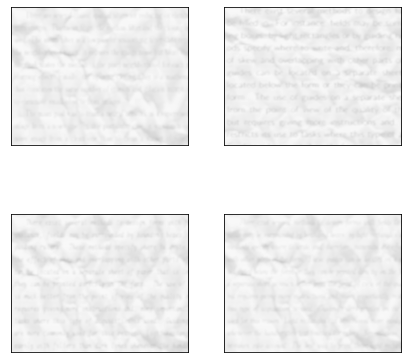

Epoch [10/30], loss = 0.31


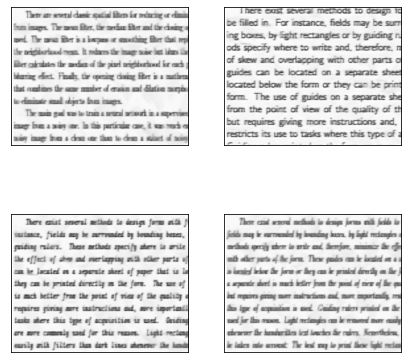

Epoch [20/30], loss = 0.25


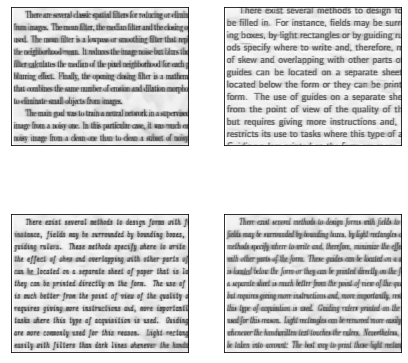

Epoch [30/30], loss = 0.31


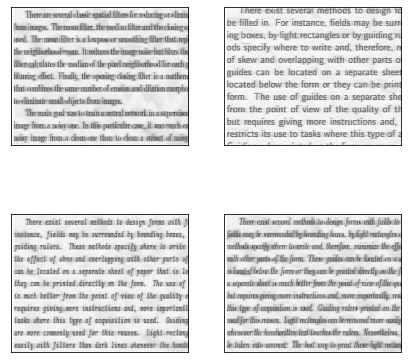

In [18]:
from torch.autograd import Variable
from IPython import display
import time
import itertools
# image plot frame
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Train start
epochs = 30
loss_total = []
start_time = time.time()

for epoch in range(epochs):
    for n, (image, label) in enumerate(train_loader):
        image, label = Variable(image.cuda()), Variable(label.cuda())
        optimizer.zero_grad()
        output = Net(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        loss_total.append(loss.item())
        
    # valid per 10 epoch 
    if epoch == 0 or (epoch+1) % 10 == 0:
        valid_image = X_valid[:4]
        valid_image = Net(Variable(valid_image.reshape(4, 1, 420, 540).cuda()))
        for i in range(4):
            y = i // 2
            x = i % 2
            ax[x,y].cla()
            ax[x,y].imshow(valid_image[i,0].data.cpu().numpy(), cmap='gray')
        plt.savefig('./simple_CAE_{:d}.png'.format(epoch+1))
        print('Epoch [{:d}/{:d}], loss = {:0.2f}'.format(epoch+1, epochs, loss))
        if epoch != epochs-1:
            display.display(plt.gcf())

end_time = time.time()

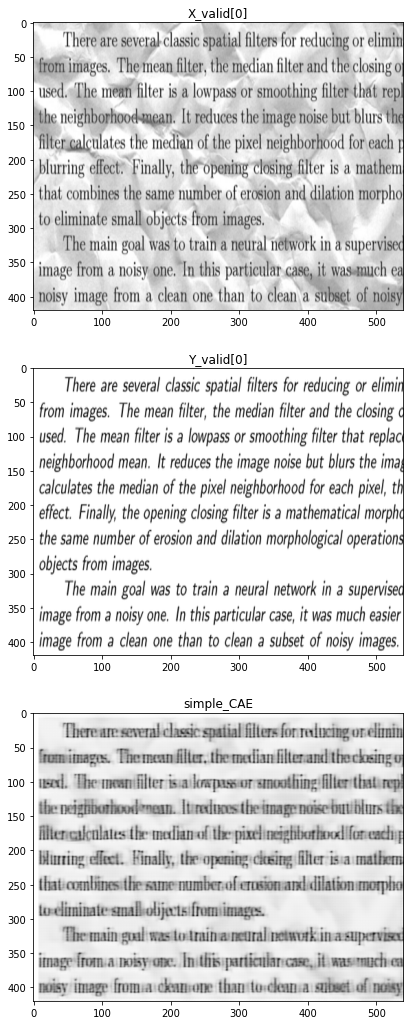

In [19]:
# for valid image[0] comparision
image = Net(Variable(X_valid[0].reshape(1, 1, 420, 540).cuda()))
image = image.data.cpu().numpy().reshape(420, 540)
image = image.clip(0, 1)
%matplotlib inline
plt.figure(figsize=(14, 18))
plt.subplot(3,1,1)
plt.title('X_valid[0]')
plt.imshow(X_valid[0].reshape(420, 540), cmap='gray')
plt.subplot(3,1,2)
plt.title('Y_valid[0]')
plt.imshow(Y_valid[0].reshape(420, 540), cmap='gray')
plt.subplot(3,1,3)
plt.title('simple_CAE')
plt.imshow(image, cmap='gray')